In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pykitti
import sys
from tqdm import tqdm
import scipy
import scipy.linalg
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
from sklearn.metrics import mean_squared_error
from ahrs.filters import AngularRate
sys.path.append('../src')

from utils import lla_to_enu, normalize_angles, get_rigid_transformation
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

%matplotlib inline
np.random.seed(777)

In this notebook, Unscented Kalman filter is introduced to the Kitti dataset. In Extended Kalman filter, the motion model is linearized using first-order Taylor expansion to approximate the nonlinear function about mean value of the random variable. However, uncertainty of the distribution, covariance, is not accurately reflect the actual distribution resulting in introducing large error in the true posterior mean and covariance of the transformed gaussian random variable.

Unlike KEF, the state distribution is approximated by a gaussian random variable represented by a minimal set of carefully chosen sample points (deterministic sampling approach).


## Unscented Kalman filter

Unscented Kalman filter approximate nonlinear motion model by using unscented transform instead of analytical transform that EKF performs. The unscented transformation is a method for calculating the mean and covariance of a random variable by passing it through a nonlinear function.

Like other filtering technique, Unscented Kalman filter follows the time update and measurement update steps.

In the time update step:

Suppose we have a random variable $x^{L}$, we compute a subset of points, called as sigma point, $\chi_{(i)}$, where i = 1...2L+1. Then a sigma vector $\chi$ is formed as follows:

$$\begin{align}
 \chi_{k-1}^{(i)} &= \hat{x_{k-1}} \\
 \chi_{k-1}^{(i)} &= \hat{x_{k-1}} + (\sqrt{(L+\lambda)*P_{x}})_{i}, i=1, ..., L\\
 \chi_{k-1}^{(i)} &= \hat{x_{k-1}} - (\sqrt{(L+\lambda)*P_{x}})_{i}, i=L+1, ..., 2L\\
\end{align}
$$
where, $\lambda$ is a caling parameter $\lambda = \alpha^{2}(L+k) - L$. $\alpha$ determins the spread of the sigma points around the sample mean $\hat{x}$, which is normally small positive value such as 0.001. Moreover, k is secondary scaling parameter, which is usually set to 0.

The number of sigma points required to approximate the nonlinearly transformed distribution is $2L + 1$. So, sigma points are chosen one point for the mean, and pair of points for the symetrically distributed about the mean.

Next, these sigma points are propagated through the nonlinear function:
$$\begin{align}
 \chi_{k-1}^{(i)} &= g(\chi_{k-1}^{(i)}, w_{k-1}, 0)
\end{align}
$$.

After propagation of all sigma points, sample mean and sample covariance of the propagated points are computed as follows:
$$\begin{align}
 \hat{x_{k}^{-}} &= \sum_{i=0}^{2L} W^{m}_{i}*\chi_{k-1}^{(i)}\\
 \hat{P_{x,k}} &= \sum_{i=0}^{2L} W^{c}_{i}*(\chi_{k-1}^{(i)} - \hat{x_{k}^{-}})(\chi_{k-1}^{(i)} - \hat{x_{k}^{-}})^{T} + Q_{k-1}
\end{align}
$$
where, Q is additive process noise.

In the measurement update step:

Once we obtain sample mean and covariance of propagated points, we predict measurement from the propagated sigma points.
$$\begin{align}
 z^{(i)}_{k, approx} &= h(\chi_{k-1}^{(i)}, w_{k-1}, 0)
\end{align}
$$

Finally, the approximated mean and covariance from the predicted measurements:
$$\begin{align}
 y_{k} &= \sum_{i=0}^{2L} W^{m}_{i}*z^{(i)}_{k, approx}\\
 \hat{P_{y,k}} &= \sum_{i=0}^{2L} W^{c}_{i}*(z^{(i)}_{k, approx} - y_{k})(z^{(i)}_{k, approx} - y_{k})^{T} + R_{k}
\end{align}
$$.

Besides the estimation, cross-covariance between propagated distribution and distribution of predicted measurement is computed as follows:
$$\begin{align}
 \hat{P_{xy,k}} &= \sum_{i=0}^{2L} W^{c}_{i}*(\chi_{k-1}^{(i)} - \hat{x_{k}^{-}})(z^{(i)}_{k, approx} - y^{(i)}_{k})^{T}
\end{align}
$$

Finally, Kalman gain and correction of the mean and covariance are performed as follows:
$$\begin{align}
 K_{k} &= \hat{P_{xy,k}} * \hat{P_{y,k}^{-1}}\\
 \hat{x_{k}} &= \hat{x_{k}^{-}} + K_{k}*(z_{k, actual} - y_{k})\\
 P_{k} &= \hat{P_{x,k}} - K_{k}*\hat{P_{y,k}}*K_{k}^{T}
\end{align}
$$
where $z_{k, actual}$ is sensor reading in measurement update step.


## Load raw data 0033

In [2]:
kitti_root_dir = '../data'
kitti_date = '2011_09_30'
kitti_drive = '0033'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)
vo = np.load("../vo_estimates/trajectory_estimated_09.npy")
gt = np.load("../vo_estimates/trajectory_gt_09.npy")
imu = np.load("../vo_estimates/imu_09.npy")

T_velo_ref0 = get_rigid_transformation('../data/2011_09_30/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation('../data/2011_09_30/calib_imu_to_velo.txt')

T_from_imu_to_cam = T_imu_velo @ T_velo_ref0
T_from_cam_to_imu = np.linalg.inv(T_from_imu_to_cam)

Extract vehicle GPS trajectory, yaw angle, yaw rate, and forward velocity from KITTI OXTS senser packets.

In [3]:
# Extract timestamps from KITTI data and convert them to seconds elapsed from the first one.
timestamps = np.array(dataset.timestamps[:gt.shape[1]])
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed] # dt

In [4]:
N = len(ts)
N

1591

In [5]:
GPS_measurements = []  # [longitude(deg), latitude(deg), altitude(meter)] x N from GPS
VO_measurements = [] # [longitude(deg), latitude(deg)] x N from Visual Odometry
IMU_outputs = [] # [acc_x, acc_y, acc_z, ang_vel_x, ang_vel_y, ang_vel_z] x N from IMU
INS_angles = [] # [roll(rad), pitch(rad), yaw(rad)] x N
INS_velocities = [] # [forward velocity, leftward velocity, upward velocity] x N from INS

for index, oxts_data in enumerate(dataset.oxts):
    if index < N:
        packet = oxts_data.packet
        # GPS_measurements.append([
        #     packet.lon,
        #     packet.lat,
        #     packet.alt
        # ])
        IMU_outputs.append([
            packet.ax,
            packet.ay,
            packet.az,
            packet.wx,
            packet.wy,
            packet.wz
        ])
        INS_angles.append([
            packet.roll,
            packet.pitch,
            packet.yaw
        ])
        INS_velocities.append([
            packet.vf,
            packet.vl,
            packet.vu
        ])
    
GPS_measurements = np.array(gt).T
VO_measurements = np.array(vo[:N])
IMU_outputs = np.array(IMU_outputs)
INS_angles = np.array(INS_angles)
INS_velocities = np.array(INS_velocities)

In [6]:
print("Shape:")
print(f'GPS: {GPS_measurements.shape}')
print(f'VO: {VO_measurements.shape}')
print(f'IMU: {IMU_outputs.shape}')
print(f'INS angle: {INS_angles.shape}')
print(f'INS velocity: {INS_velocities.shape}')

Shape:
GPS: (1591, 3)
VO: (1591, 3)
IMU: (1591, 6)
INS angle: (1591, 3)
INS velocity: (1591, 3)


### Display Ground truth data

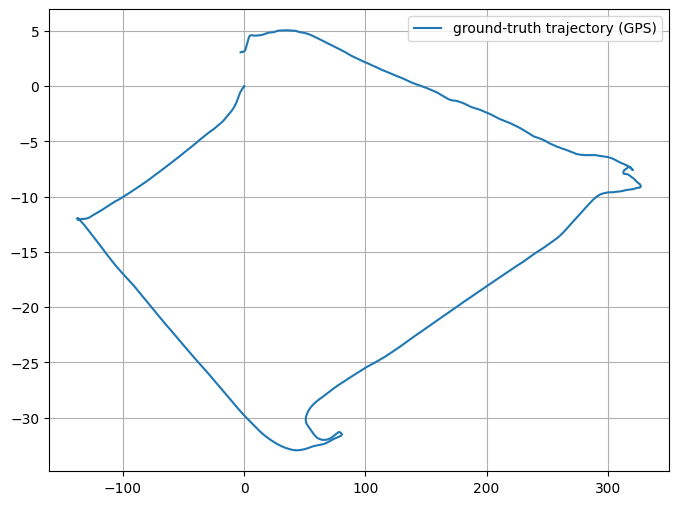

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
lons, lats, _ = GPS_measurements.T
ax.plot(lons, lats, label='ground-truth trajectory (GPS)')
ax.legend()
ax.grid()

### transform GPS data into imu coordinate

In [8]:
GPS_measurements_in_meter = []
for gt_est in GPS_measurements:
    lla_values = np.array([gt_est[0], gt_est[1], gt_est[2], 1])
    transformed_lla_values = T_from_cam_to_imu @ lla_values
    GPS_measurements_in_meter.append([transformed_lla_values[0], 
                             transformed_lla_values[1], 
                             transformed_lla_values[2]])

GPS_measurements_in_meter = np.array(GPS_measurements_in_meter)

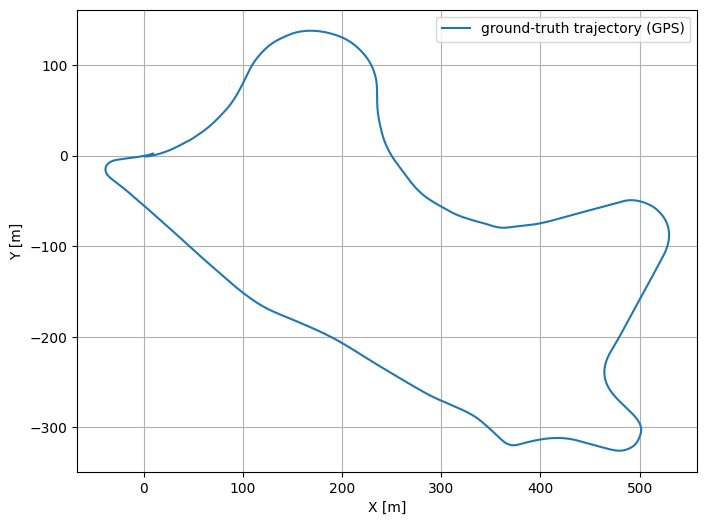

In [9]:
xs, ys, _ = GPS_measurements_in_meter.T
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys, label='ground-truth trajectory (GPS)')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid();

### transform VO data into imu coordinate

In [10]:
vo_array = []
for vo_est in VO_measurements:
    VO = np.array([vo_est[0], vo_est[1], vo_est[2], 1])
    transformed = T_from_cam_to_imu @ VO
    vo_array.append([transformed[0], transformed[1], transformed[2]])

VO_measurements = np.array(vo_array)

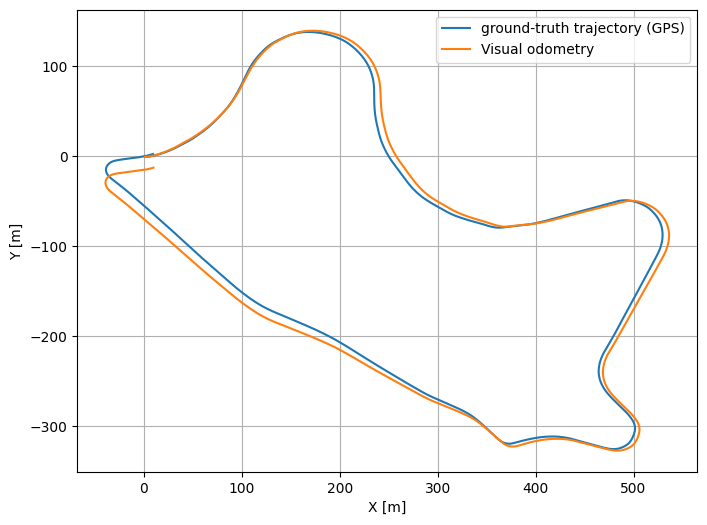

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

xs, ys, _ = GPS_measurements_in_meter.T
ax.plot(xs, ys, label='ground-truth trajectory (GPS)')
xs, ys, _ = VO_measurements.T
ax.plot(xs, ys, label='Visual odometry')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid();

## Adding gaussian noise to KITTI INS/IMU data

Now we have following measurement values:

x and y values obtained from GPS sensor
linear acceleration along x, y, and z axis from IMU sensor
angular velocity about x, y, and z axis acquired from IMU sensor
forward, leftword, upword velociteies along x, y, z from INS sensor
angle about x, y, z from INS sensor
To design measurement step, we add white gaussian noise to the sensor reading denoted as measurement noise matrix R in the filter.

### Add noise to GPS data

In [12]:
GPS_measurements_in_meter.shape

(1591, 3)

In [13]:
GPS_measurement_noise_std = 1.0  # standard deviation of observation noise of x and y in meter. so 95% of x and y values fall inside +- 2m from the ground truth.

_gps_noise = np.random.normal(0.0, GPS_measurement_noise_std, (N, 2))  # gen gaussian noise
GPS_mesurement_in_meter_with_noise = GPS_measurements_in_meter.copy()
GPS_mesurement_in_meter_with_noise[:, :2] += _gps_noise  # add the noise to ground-truth x and y positions

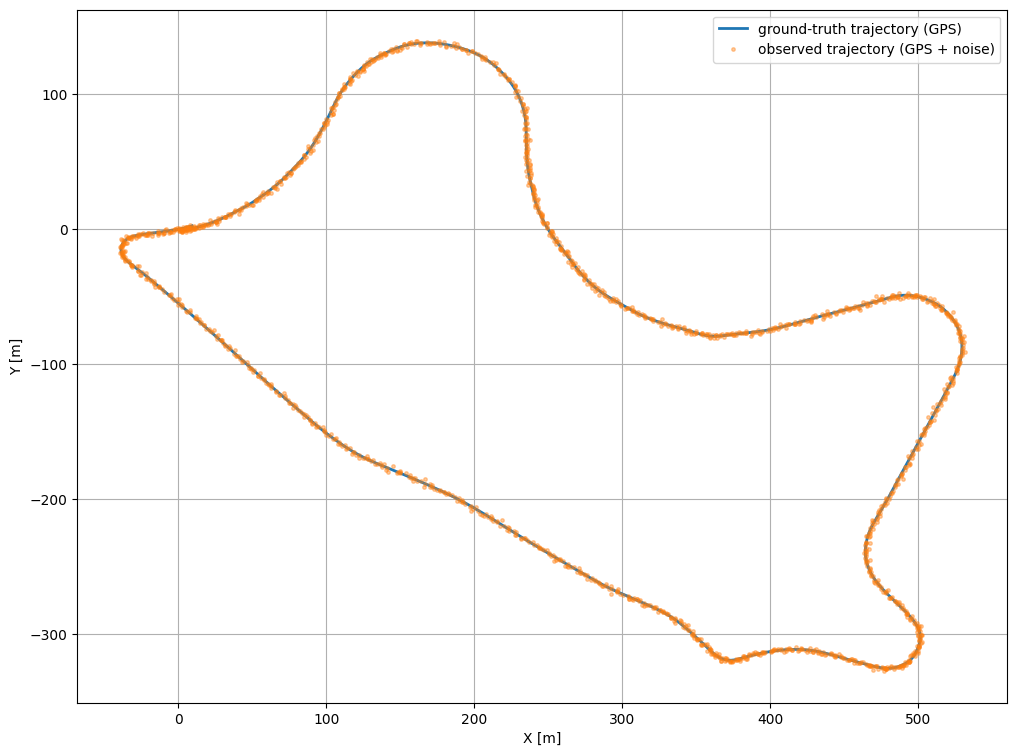

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter.T
ax.plot(xs, ys, lw=2, label='ground-truth trajectory (GPS)')

xs, ys, _ = GPS_mesurement_in_meter_with_noise.T
ax.plot(xs, ys, lw=0, marker='.', markersize=5, alpha=0.4, label='observed trajectory (GPS + noise)')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

### Adding noise to VO data

In [15]:
VO_noise_std = 1.0  # standard deviation of observation noise of x and y in meter. so 95% of x and y values fall inside +- 2m from the ground truth.

_vo_noise = np.random.normal(0.0, VO_noise_std, (N, 2))  # gen gaussian noise
VO_measurements_with_noise = VO_measurements.copy()
VO_measurements_with_noise[:, :2] += _vo_noise  # add the noise to ground-truth x and y positions

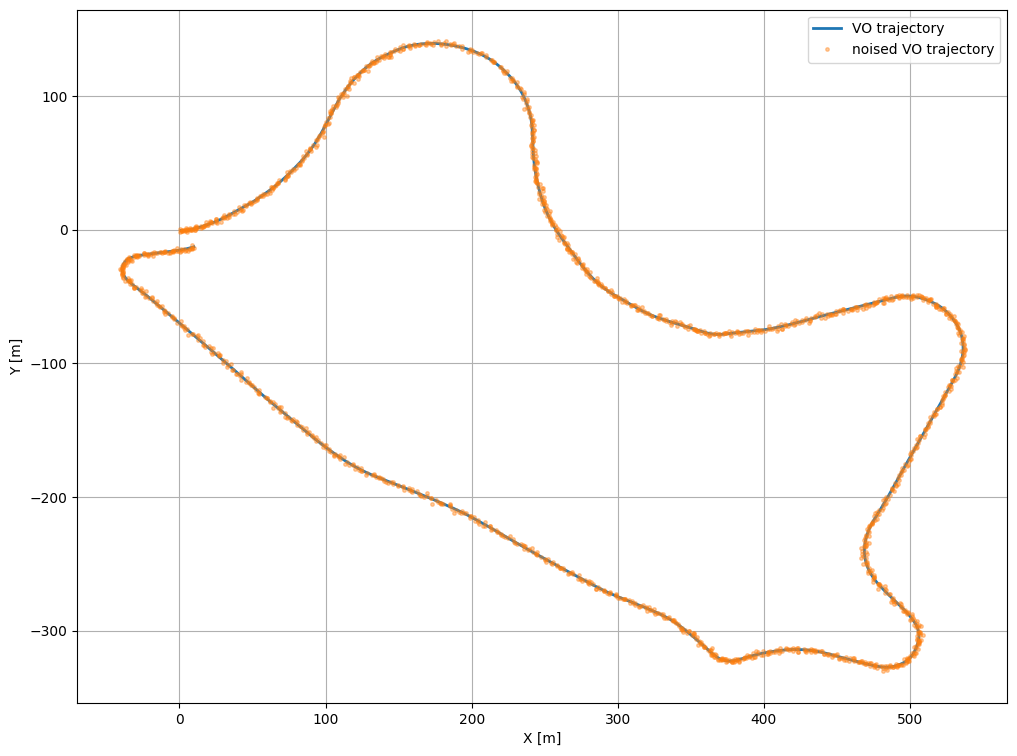

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = VO_measurements.T
ax.plot(xs, ys, lw=2, label='VO trajectory')

xs, ys, _ = VO_measurements_with_noise.T
ax.plot(xs, ys, lw=0, marker='.', markersize=5, alpha=0.4, label='noised VO trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

### Adding noise to IMU sensor data¶

#### Acceleration

In [17]:
IMU_acc_noise_std = 0.02

IMU_acc_noise = np.random.normal(0.0, IMU_acc_noise_std,(N, 3))  # gaussian noise
IMU_acc_with_noise = IMU_outputs[:, :3].copy()
IMU_acc_with_noise += IMU_acc_noise

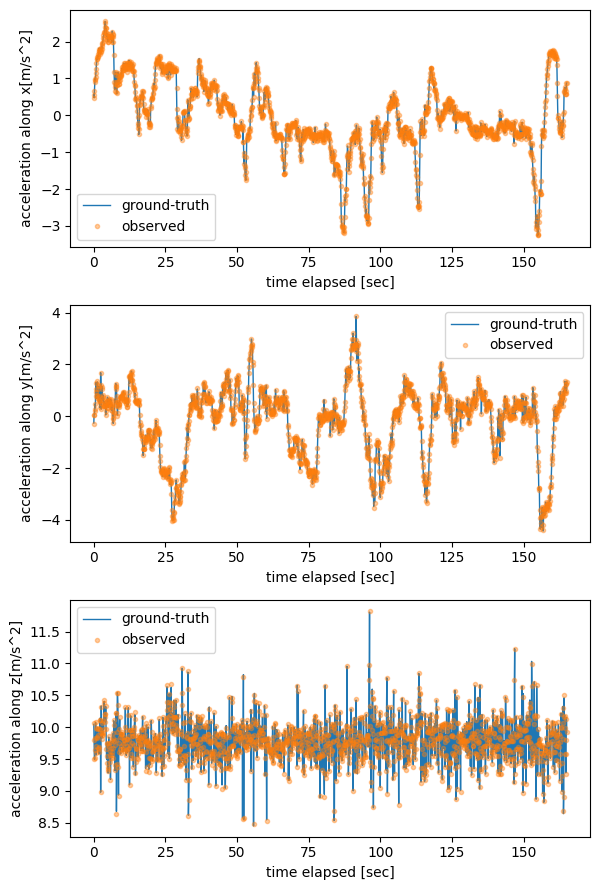

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
acc_y_labels = ['acceleration along x[m/s^2]', 'acceleration along y[m/s^2]', 'acceleration along z[m/s^2]']

for idx in range(1, 4):  
    i = idx - 1
    ax[i].plot(ts, IMU_outputs[:, idx-1:idx], lw=1, label='ground-truth')
    ax[i].plot(ts, IMU_acc_with_noise[:, idx-1:idx], lw=0, marker='.', alpha=0.4, label='observed')
    ax[i].set_xlabel('time elapsed [sec]')
    ax[i].set_ylabel(acc_y_labels[i])
    ax[i].legend()
fig.tight_layout()

#### Angular velocity

In [19]:
IMU_angular_velocity_noise_std = 0.01 # standard deviation of yaw rate in rad/s

IMU_angular_velocity_noise = np.random.normal(0.0, IMU_angular_velocity_noise_std, (N,3))  # gen gaussian noise
IMU_angular_velocity_with_noise = IMU_outputs[:, 3:].copy()
IMU_angular_velocity_with_noise += IMU_angular_velocity_noise  # add the noise to angular velocity as measurement noise

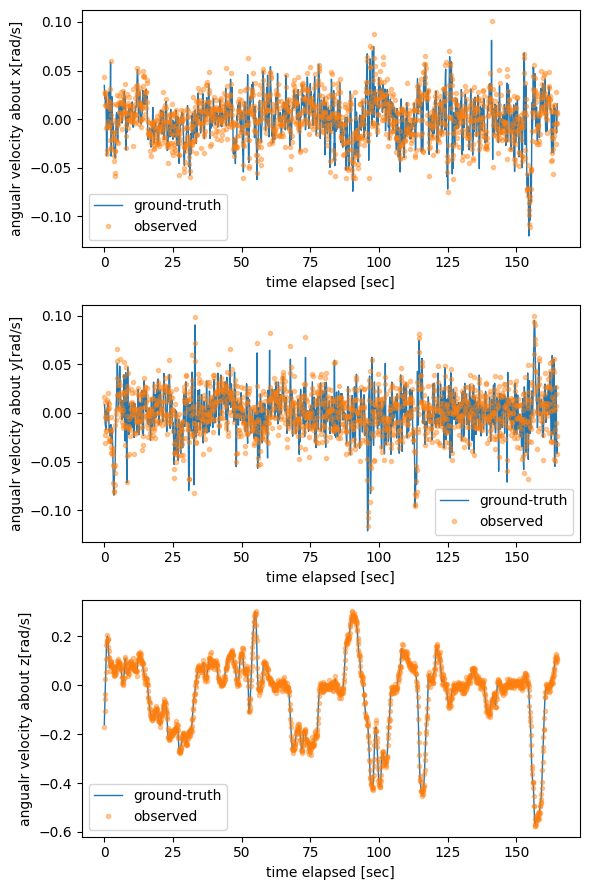

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
angualr_vel_y_labels = ['angualr velocity about x[rad/s]', 'angualr velocity about y[rad/s]', 'angualr velocity about z[rad/s]']

for idx in range(3):  
    i = idx + 4
    ax[idx].plot(ts, IMU_outputs[:, i-1:i], lw=1, label='ground-truth')
    ax[idx].plot(ts, IMU_angular_velocity_with_noise[:, idx:idx+1], lw=0, marker='.', alpha=0.4, label='observed')
    ax[idx].set_xlabel('time elapsed [sec]')
    ax[idx].set_ylabel(angualr_vel_y_labels[idx])
    ax[idx].legend()
fig.tight_layout()

In [21]:
angular_rate = AngularRate(gyr=IMU_angular_velocity_with_noise)

In [22]:
IMU_quaterion = angular_rate.Q

### Adding noise to linear velocity data

In [23]:
INS_velocities.shape

(1591, 3)

In [24]:
velocity_noise_std = 0.3
velocity_noise = np.random.normal(0.0, velocity_noise_std, (N, 3))
INS_velocities_with_noise = INS_velocities.copy()
INS_velocities_with_noise += velocity_noise

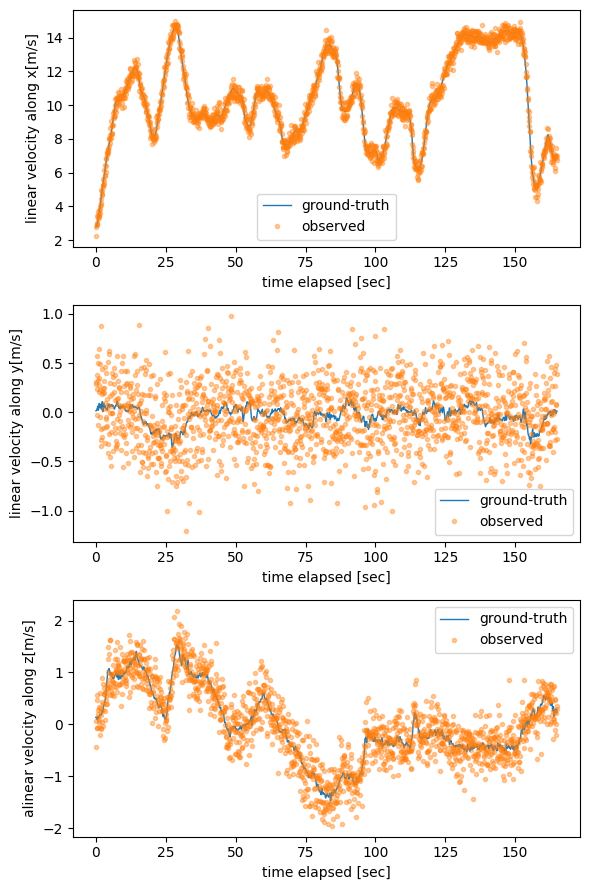

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
linear_velocity_y_labels = ['linear velocity along x[m/s]', 'linear velocity along y[m/s]', 'alinear velocity along z[m/s]']

for idx in range(1, 4):  
    i = idx - 1
    ax[i].plot(ts, INS_velocities[:, idx-1:idx], lw=1, label='ground-truth')
    ax[i].plot(ts, INS_velocities_with_noise[:, idx-1:idx], lw=0, marker='.', alpha=0.4, label='observed')
    ax[i].set_xlabel('time elapsed [sec]')
    ax[i].set_ylabel(linear_velocity_y_labels[i])
    ax[i].legend()
fig.tight_layout()

# Applying Unscented Kalman filter

In [26]:
errors = []
error_vo = mean_squared_error(GPS_measurements_in_meter.T[:2, :], VO_measurements.T[:2, :])
print(f"MSE: {error_vo}")
errors.append(error_vo)

MSE: 29.686680309859263


--------------

## Setup1 (IMU input -> EKF with Visual Odometry measurement)

In [27]:
class UnscentedKalmanFilter:

    x = None
    P = None
    sigma_points = None
    chi = None

    errors = []
    
    def __init__(self, x, P, H, alpha=1e-3, beta=2., kappa=0):
        self.N = len(x)
        self.x = x
        self.P = P
        self.H = H
        # self.lambda_ = alpha**2*(self.N + k) - self.N
        self.points = MerweScaledSigmaPoints(n=self.N, alpha=alpha, beta=beta, kappa=.1)
        self.lambda_ = 3 - self.N
        W_m0 = np.array([self.lambda_/(self.N + self.lambda_)])
        W_c0 = np.array([self.lambda_/(self.N + self.lambda_) + (1 - alpha**2 + beta)])
        W_1_N = np.array([1/(2*(self.N + self.lambda_)) for _ in range(2*self.N)])
        self.W_m = np.concatenate([W_m0, W_1_N])
        self.W_c = np.concatenate([W_c0, W_1_N])

    def compute_sigma_points(self):
        # chi = self.x
        # chi1 = self.x + np.sqrt((self.N+self.lambda_)*self.P)
        # chi2 = self.x - np.sqrt((self.N+self.lambda_)*self.P)
        # L = scipy.linalg.cholesky(P_initial, lower=True)
        # chi = ukf1.x
        # coeff = np.sqrt(ukf1.N+ukf1.lambda_)
        # chi1 = np.array([chi + coeff * L[:, i].reshape(-1, 1) for i in range(L.shape[0])]).reshape(self.N, self.N)
        # chi2 = np.array([chi - coeff * L[:, i].reshape(-1, 1) for i in range(L.shape[0])]).reshape(self.N, self.N)
        # return np.concatenate((chi.reshape(1, -1), chi1, chi2), axis=0)
        return self.points.sigma_points(self.x.reshape(-1,), self.P)
        
    def compute_norm_w(self, w):
        return np.sqrt(np.sum(w**2))

    def get_rotation_matrix(self, q):
        q1, q2, q3, q4 = q[:, 0]
        return np.array([
            [q1**2 + q2**2 - q3**2 - q4**2, 2*(q2*q3 - q1*q4), 2*(q1*q3 + q2*q4)],
            [2*(q2*q3 + q1*q4), q1**2 - q2**2 + q3**2 - q4**2, 2*(q3*q4 - q1*q2)],
            [2*(q2*q4 - q1*q3), 2*(q1*q2 + q3*q4), q1**2 - q2**2 - q3**2 + q4**2]
           ])
        
    def get_quaternion_update_matrix(self, w):
        wx, wy, wz = w[:, 0]
        return np.array([
            [0, wz, -wy, wx],
            [-wz, 0, wx, wy],
            [wy, -wx, 0, wz],
            [-wx, -wy, -wz, 0]
        ])

    def predict(self, u, dt, Q):

        chi = self.compute_sigma_points()
        p = chi[:, :3]
        v = chi[:, 3:6]
        q = chi[:, 6:]
        a = u[:3]
        w = u[3:]
        a = a.reshape(-1, 1)
        w = w.reshape(-1, 1)
        g = np.array([[0],[0],[9.81]])
        R = np.array([self.get_rotation_matrix(q_.reshape(-1, 1)) for q_ in q]) #21x3x3
        Omega = self.get_quaternion_update_matrix(w)
        norm_w = self.compute_norm_w(w)

        A = np.cos(norm_w*dt/2) * np.eye(4)
        B = (1/norm_w)*np.sin(norm_w*dt/2) * Omega

        acc_val = (R @ a - g)
        acc_val_reshaped = acc_val.reshape(acc_val.shape[0], acc_val.shape[1])
        p_k = p + v * dt + acc_val_reshaped*dt**2 / 2 # 21x3
        v_k = v + acc_val_reshaped * dt # 21x3
        q_k = q @ np.array(A + B) # 21x4
        
        self.chi = np.concatenate([
            p_k,
            v_k,
            q_k,
        ], axis=1) # 21x10
        

        # self.x = (self.W_m @ self.chi).reshape(-1, 1) # 10x1
        self.x = (self.points.Wm @ self.chi).reshape(-1, 1) # 10x1
        p_ = np.zeros((self.N, self.N)) # 10x10
        for i, sigma_point in enumerate(self.chi):
            p_ += self.points.Wc[i] * (sigma_point.reshape(-1, 1) - self.x) @ (sigma_point.reshape(-1, 1) - self.x).T
            # p_ += self.W_c[i] * (sigma_point.reshape(-1, 1) - self.x) @ (sigma_point.reshape(-1, 1) - self.x).T
        self.P = p_ + Q # 10x10 additive process noise
    
    def update(self, z, R):
        chi = self.compute_sigma_points()
        y_sigma_points = chi @ self.H.T # 21x2
        # y_hat = (self.W_m @ y_sigma_points).reshape(-1, 1) # 2x1
        y_hat = (self.points.Wm @ y_sigma_points).reshape(-1, 1) # 2x1

        x_dim = chi.shape[1]
        z_dim = y_sigma_points.shape[1]
        P_y = np.zeros((z_dim, z_dim)) # 2x2
        for i, y_sigma_point in enumerate(y_sigma_points):
            # P_y += self.W_c[i] * (y_sigma_point.reshape(-1, 1) - y_hat) @ (y_sigma_point.reshape(-1, 1) - y_hat).T
            P_y += self.points.Wc[i] * (y_sigma_point.reshape(-1, 1) - y_hat) @ (y_sigma_point.reshape(-1, 1) - y_hat).T
        P_y += R # additive measurement noise
        
        P_xy = np.zeros((x_dim, z_dim)) # 10x2
        for idx in range(self.N):
            # P_xy += self.W_c[idx] * ((chi[idx].reshape(-1, 1) - self.x) @ (y_sigma_points[idx].reshape(-1, 1) - y_hat).T)
            P_xy += self.points.Wc[idx] * ((chi[idx].reshape(-1, 1) - self.x) @ (y_sigma_points[idx].reshape(-1, 1) - y_hat).T)
            
        K = P_xy @ np.linalg.inv(P_y)
        residual = z.reshape(-1, 1) - y_hat
        self.x = self.x + K @ residual
        self.P = self.P - K @ P_y @ K.T
        
        self.errors.append(np.sqrt(np.sum(residual**2)))
    
    def plot_error(self):
        plt.plot([i for i in range(len(self.errors))], self.errors, label='Error', color='r')

In [28]:
# initial values
px_, py_, pz_ = VO_measurements[0, :]
q1_, q2_, q3_, q4_ = IMU_quaterion[0]
ax_, ay_, az_ = IMU_acc_with_noise[0]
wx_, wy_, wz_ = IMU_angular_velocity_with_noise[0]

x_initial = np.array([
    [px_], #Px
    [py_], #Py
    [pz_], #Pz
    [0], #Vx
    [0], #Vy
    [0], #Vz
    [q1_], #q1
    [q2_], #q2
    [q3_], #q3
    [q4_]  #q4
]) # 10x1

P_initial = np.eye(x_initial.shape[0]) * 0.001
# transition matrix from predicted state vector to measurement space
H_initial = np.array([
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
])
# process noise
# q_noise = [IMU_acc_noise_std, IMU_acc_noise_std, IMU_acc_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std]
# q_noise = []
# i = np.eye(10)
# Q_ = np.array([[val * num for num in i[ind]] for ind, val in enumerate(q_noise)])
Q_ = np.eye(10) * 0.1
# measurement noise
VO_noise_std2 = VO_noise_std * 1.
R_ = np.array([
    [VO_noise_std2 ** 2., 0.],
    [0., VO_noise_std2 ** 2.],
])
ukf1 = UnscentedKalmanFilter(x=x_initial, 
                             P=P_initial, 
                             H=H_initial,
                             alpha=.1,
                             beta=2,
                             kappa=3
                            )

In [29]:
mu_x_ukf1 = [ukf1.x[0, 0],]
mu_y_ukf1 = [ukf1.x[1, 0],]
t_last = 0.

for t_idx in tqdm(range(1, N)):
    t = ts[t_idx]
    dt_ = t - t_last
    ax_, ay_, az_ = IMU_acc_with_noise[t_idx]
    wx_, wy_, wz_ = IMU_angular_velocity_with_noise[t_idx]
    u_ = np.array([
        ax_,
        ay_,
        az_,
        wx_,
        wy_,
        wz_
    ])
    ukf1.predict(u=u_, dt=dt_, Q=Q_)
    x_hat = ukf1.x.copy()
    mu_x_ukf1.append(x_hat[0, 0])
    mu_y_ukf1.append(x_hat[1, 0])
    z_ = VO_measurements[t_idx, :2]
    ukf1.update(z=z_.reshape(-1, 1), R=R_)
    t_last = t

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1590/1590 [00:00<00:00, 2616.42it/s]


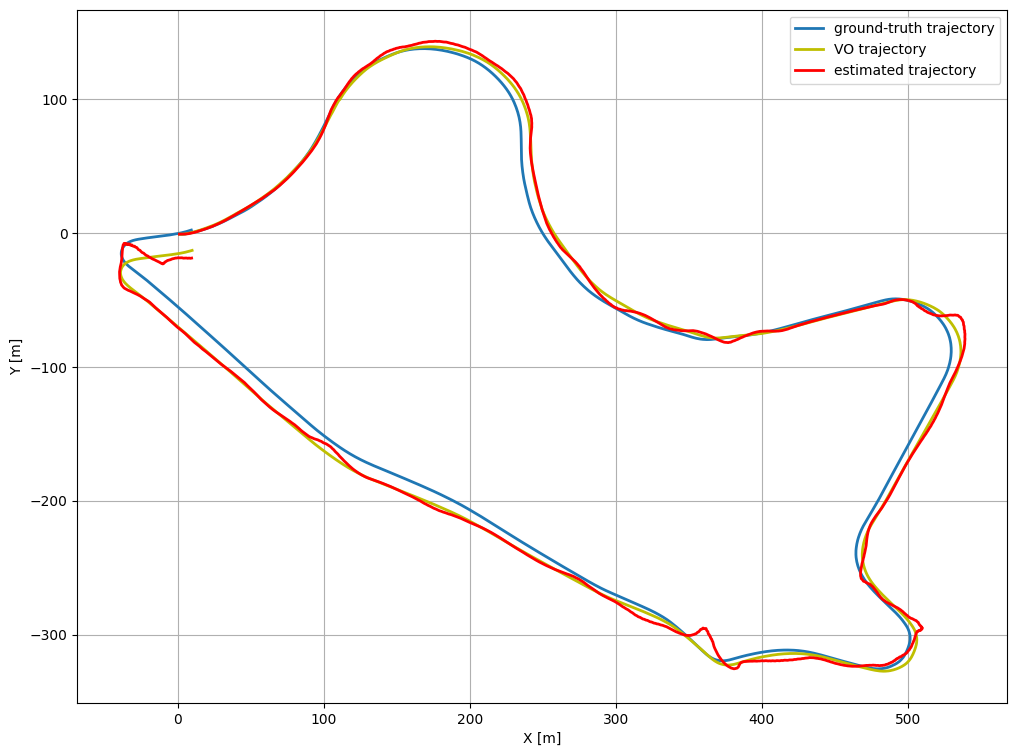

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter.T
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = VO_measurements.T
ax.plot(xs, ys, lw=2, markersize=4, alpha=1., label='VO trajectory', color='y')

ax.plot(mu_x_ukf1, mu_y_ukf1, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [31]:
error_ukf1 = mean_squared_error(GPS_measurements_in_meter.T[:2, :len(mu_x_ukf1)], np.array([mu_x_ukf1, mu_y_ukf1]))
print(f"MSE: {error_ukf1}")
errors.append(error_ukf1)

MSE: 35.61131380602317


## Setup2 (IMU input -> EKF with Visual Odometry and GPS measurement)

In [32]:
# initial values
px_, py_, pz_ = VO_measurements[0, :]
q1_, q2_, q3_, q4_ = IMU_quaterion[0]
ax_, ay_, az_ = IMU_acc_with_noise[0]
wx_, wy_, wz_ = IMU_angular_velocity_with_noise[0]

x_initial = np.array([
    [px_], #Px
    [py_], #Py
    [pz_], #Pz
    [0], #Vx
    [0], #Vy
    [0], #Vz
    [q1_], #q1
    [q2_], #q2
    [q3_], #q3
    [q4_]  #q4
])
P_initial = np.eye(x_initial.shape[0]) * 0.001
# transition matrix from predicted state vector to measurement space
# H_initial = np.array([
#     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
#     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
#     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
#     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
# ])
H_initial = np.array([
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
])
# process noise
# q_noise = [IMU_acc_noise_std, IMU_acc_noise_std, IMU_acc_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std, IMU_angular_velocity_noise_std]
# i = np.eye(6)
# Q_ = np.array([[val * num for num in i[ind]] for ind, val in enumerate(q_noise)])
Q_ = np.eye(10) * 0.1
# measurement noise
# GPS_measurement_noise_std_2 = VO_noise_std / 2
VO_noise_std_2 = VO_noise_std
GPS_measurement_noise_std_2 = GPS_measurement_noise_std

# R_ = np.array([
#     [VO_noise_std_2 ** 2., 0., 0., 0.],
#     [0., VO_noise_std_2 ** 2., 0., 0.],
#     [0., 0., GPS_measurement_noise_std_2 ** 2., 0.],
#     [0., 0., 0., GPS_measurement_noise_std_2 ** 2.],
# ])
R_vo = np.array([
    [VO_noise_std_2 ** 2., 0.],
    [0., VO_noise_std_2 ** 2.]
])
R_gps = np.array([
    [GPS_measurement_noise_std_2 ** 2., 0.],
    [0., GPS_measurement_noise_std_2 ** 2.]
])
# R_ = np.array([
#     [GPS_measurement_noise_std ** 2., 0.],
#     [0., GPS_measurement_noise_std ** 2.]
# ])

ukf2 = UnscentedKalmanFilter(x=x_initial, 
                             P=P_initial, 
                             H=H_initial,
                             alpha=1e-3,
                            )

In [33]:
mu_x_ukf2 = [ukf2.x[0, 0],]
mu_y_ukf2 = [ukf2.x[1, 0],]
t_last = 0.

for t_idx in tqdm(range(1, N)):
    t = ts[t_idx]
    dt_ = t - t_last
    ax_, ay_, az_ = IMU_acc_with_noise[t_idx]
    wx_, wy_, wz_ = IMU_angular_velocity_with_noise[t_idx]
    u_ = np.array([
        ax_,
        ay_,
        az_,
        wx_,
        wy_,
        wz_
    ])
    ukf2.predict(u=u_, dt=dt_, Q=Q_)
    x_hat = ukf2.x.copy()
    mu_x_ukf2.append(x_hat[0, 0])
    mu_y_ukf2.append(x_hat[1, 0])
    z_vo_ = VO_measurements_with_noise[t_idx, :2]
    z_gps_ = GPS_mesurement_in_meter_with_noise[t_idx, :2]
    ukf2.update(z=z_vo_, R=R_vo)
    ukf2.update(z=z_gps_, R=R_gps)
    # z_ = np.concatenate([z_vo_, z_gps_]).reshape(-1, 1)
    # ukf2.update(z=z_, R=R_)
    t_last = t

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1590/1590 [00:00<00:00, 2396.05it/s]


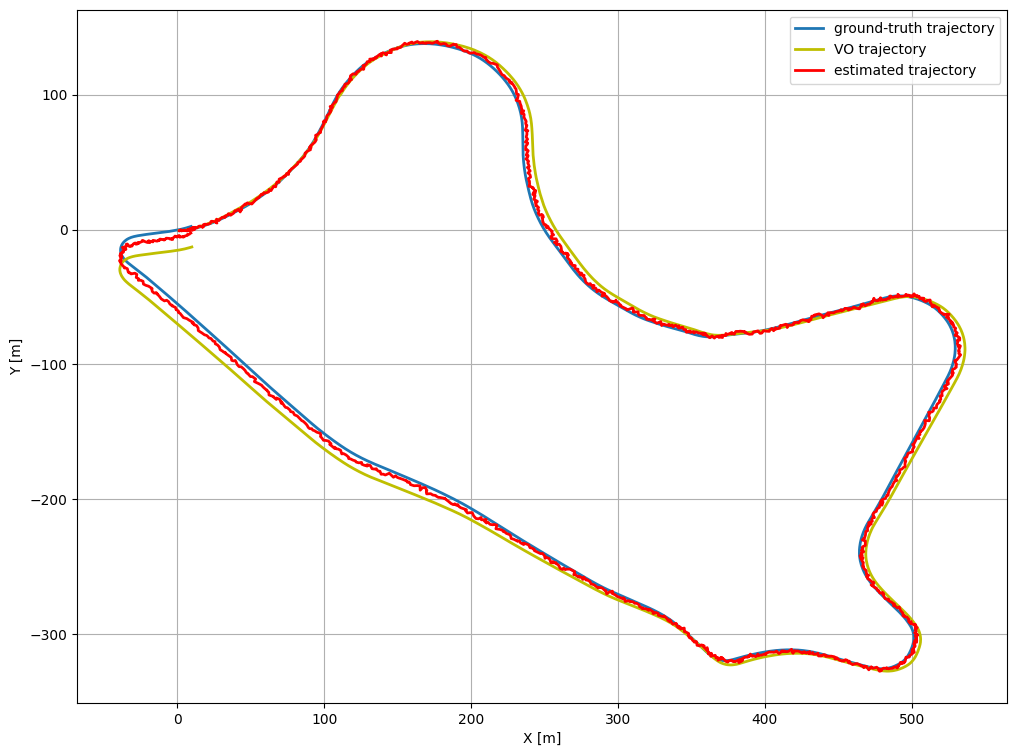

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter.T
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = VO_measurements.T
ax.plot(xs, ys, lw=2, label='VO trajectory', color='y')

ax.plot(mu_x_ukf2, mu_y_ukf2, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [35]:
error_ukf2 = mean_squared_error(GPS_measurements_in_meter.T[:2, :len(mu_x_ukf2)], np.array([mu_x_ukf2, mu_y_ukf2]))
print(f"MSE: {error_ukf2}")
errors.append(error_ukf2)

MSE: 4.369743764593403


## Setup3 (INS input -> EKF with Visual Odometry and INS measurement)

In [36]:
class UnscentedKalmanFilter_3:

    x = None
    P = None
    sigma_points = None
    chi = None

    errors = []
    
    def __init__(self, x, P, H, alpha=1e-3, beta=2., kappa=0):
        self.N = len(x) # 3
        self.x = x
        self.P = P
        self.H = H
        self.points = MerweScaledSigmaPoints(n=self.N, alpha=alpha, beta=beta, kappa=.1)

    def compute_sigma_points(self):
        return self.points.sigma_points(self.x.reshape(-1,), self.P)
        
    def compute_norm_w(self, w):
        return np.sqrt(np.sum(w**2))

    def get_rotation_matrix(self, q):
        q1, q2, q3, q4 = q[:, 0]
        return np.array([
            [q1**2 + q2**2 - q3**2 - q4**2, 2*(q2*q3 - q1*q4), 2*(q1*q3 + q2*q4)],
            [2*(q2*q3 + q1*q4), q1**2 - q2**2 + q3**2 - q4**2, 2*(q3*q4 - q1*q2)],
            [2*(q2*q4 - q1*q3), 2*(q1*q2 + q3*q4), q1**2 - q2**2 - q3**2 + q4**2]
           ])
        
    def get_quaternion_update_matrix(self, w):
        wx, wy, wz = w[:, 0]
        return np.array([
            [0, wz, -wy, wx],
            [-wz, 0, wx, wy],
            [wy, -wx, 0, wz],
            [-wx, -wy, -wz, 0]
        ])

    def predict(self, u, dt, Q):

        chi = self.compute_sigma_points() # 7x3
        x, y, theta = chi.T
        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)
        theta = theta.reshape(-1, 1)
        v, omega = u
        r = v / omega  # turning radius

        dtheta = omega * dt
        dx = - r * np.sin(theta) + r * np.sin(theta + dtheta)
        dy = + r * np.cos(theta) - r * np.cos(theta + dtheta)
        x += dx
        y += dy
        theta += dtheta
        
        self.chi = np.concatenate([x, y, theta], axis=1)

        self.x = (self.points.Wm @ self.chi).reshape(-1, 1) # 3x1
        p_ = np.zeros((self.N, self.N)) # 3x3
        for i, sigma_point in enumerate(self.chi):
            p_ += self.points.Wc[i] * (sigma_point.reshape(-1, 1) - self.x) @ (sigma_point.reshape(-1, 1) - self.x).T
            # p_ += self.W_c[i] * (sigma_point.reshape(-1, 1) - self.x) @ (sigma_point.reshape(-1, 1) - self.x).T
        self.P = p_ + Q # 10x10 additive process noise
    
    def update(self, z, R):
        chi = self.compute_sigma_points()
        y_sigma_points = chi @ self.H.T # 7x2
        # y_hat = (self.W_m @ y_sigma_points).reshape(-1, 1) # 2x1
        y_hat = (self.points.Wm @ y_sigma_points).reshape(-1, 1) # 2x1

        x_dim = chi.shape[1]
        z_dim = y_sigma_points.shape[1]
        P_y = np.zeros((z_dim, z_dim)) # 2x2
        for i, y_sigma_point in enumerate(y_sigma_points):
            # P_y += self.W_c[i] * (y_sigma_point.reshape(-1, 1) - y_hat) @ (y_sigma_point.reshape(-1, 1) - y_hat).T
            P_y += self.points.Wc[i] * (y_sigma_point.reshape(-1, 1) - y_hat) @ (y_sigma_point.reshape(-1, 1) - y_hat).T
        P_y += R # additive measurement noise
        
        P_xy = np.zeros((x_dim, z_dim)) # 10x2
        for idx in range(self.N):
            # P_xy += self.W_c[idx] * ((chi[idx].reshape(-1, 1) - self.x) @ (y_sigma_points[idx].reshape(-1, 1) - y_hat).T)
            P_xy += self.points.Wc[idx] * ((chi[idx].reshape(-1, 1) - self.x) @ (y_sigma_points[idx].reshape(-1, 1) - y_hat).T)
            
        K = P_xy @ np.linalg.inv(P_y)
        residual = z.reshape(-1, 1) - y_hat
        self.x = self.x + K @ residual
        self.P = self.P - K @ P_y @ K.T
        
        self.errors.append(np.sqrt(np.sum(residual**2)))
    
    def plot_error(self):
        plt.plot([i for i in range(len(self.errors))], self.errors, label='Error', color='r')

In [37]:
# state vector x
initial_x = np.array([
    VO_measurements[0, 0], #Px
    VO_measurements[0, 1], #Py
    IMU_outputs[0, 5]
])
initial_x = initial_x.reshape(-1, 1)

# covariance for state vector x
initial_P = np.eye(initial_x.shape[0]) * 0.001

# process noise
# q_noise3 = [velocity_noise_std, IMU_angular_velocity_noise_std]
# i = np.eye(2)
# Q_ = np.array([[val * num for num in i[ind]] for ind, val in enumerate(q_noise3)])
Q_ = np.array([
    [VO_noise_std ** 2., 0., 0.],
    [0., VO_noise_std ** 2., 0.],
    [0., 0., IMU_angular_velocity_noise_std ** 2.],
])

# measurement noise
VO_noise_std2 = VO_noise_std
GPS_measurement_noise_std2 = GPS_measurement_noise_std
R_vo = np.array([
    [VO_noise_std2 ** 2., 0.],
    [0., VO_noise_std2 ** 2.]
])
R_gps = np.array([
    [GPS_measurement_noise_std2 ** 2., 0.],
    [0., GPS_measurement_noise_std2 ** 2.]
])


# transition matrix H
H_ = np.array([
    [1., 0., 0.],
    [0., 1., 0.]
])
ukf3 = UnscentedKalmanFilter_3(x=initial_x, P=initial_P, H=H_, alpha=1e-3, beta=10)

In [38]:
t_last = 0.
t_idx = 1
t = ts[t_idx]
dt = t - t_last
# control vector
u = np.array([
    INS_velocities_with_noise[t_idx, 0],
    IMU_angular_velocity_with_noise[t_idx, 2]
])
vo_z_ = VO_measurements_with_noise[t_idx, :2].reshape(-1, 1)
gps_z_ = GPS_mesurement_in_meter_with_noise[t_idx, :2].reshape(-1, 1)

ukf3.predict(u=u, dt=dt, Q=Q_)
ukf3.update(z=vo_z_, R=R_vo)
ukf3.update(z=gps_z_, R=R_gps)

In [39]:
mu_x_ukf3 = [ukf3.x[0, 0],]
mu_y_ukf3 = [ukf3.x[1, 0],]
t_last = 0.

for t_idx in tqdm(range(1, N)):
    t = ts[t_idx]
    dt_ =  t - t_last
    vf_ = INS_velocities_with_noise[t_idx, 0] # forward velocity
    wz_ = IMU_angular_velocity_with_noise[t_idx, 2]
    u_ = np.array([
        vf_,
        wz_,
    ])
    ukf3.predict(u=u_, dt=dt_, Q=Q_)
    x_hat = ukf3.x.copy()
    mu_x_ukf3.append(x_hat[0, 0])
    mu_y_ukf3.append(x_hat[1, 0])
    vo_z_ = VO_measurements_with_noise[t_idx, :2].reshape(-1, 1)
    gps_z_ = GPS_mesurement_in_meter_with_noise[t_idx, :2].reshape(-1, 1)
    ukf3.update(z=vo_z_, R=R_vo)
    ukf3.update(z=gps_z_, R=R_gps)
    t_last = t

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1590/1590 [00:00<00:00, 5815.72it/s]


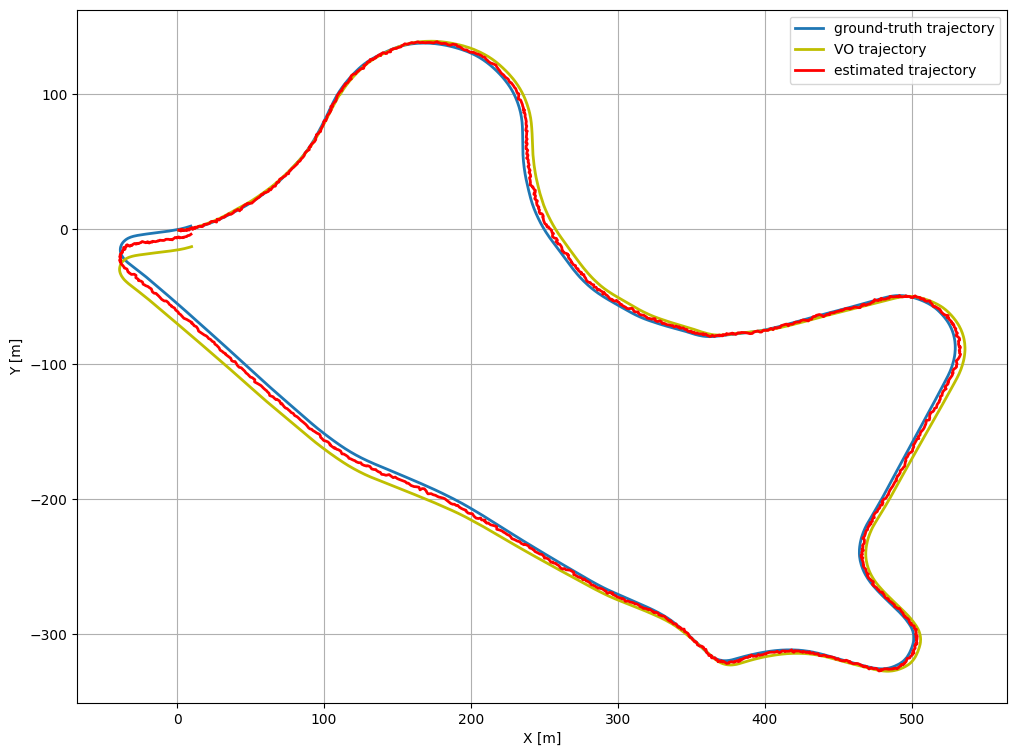

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = GPS_measurements_in_meter.T
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = VO_measurements.T
ax.plot(xs, ys, lw=2, label='VO trajectory', color='y')

ax.plot(mu_x_ukf3, mu_y_ukf3, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [41]:
error_ukf3 = mean_squared_error(GPS_measurements_in_meter.T[:2, :], np.array([mu_x_ukf3, mu_y_ukf3]))
print(f"MSE: {error_ukf3}")
errors.append(error_ukf3)

MSE: 5.091959823160613


In [42]:
error_labels = ["VO MSE error", "UKF (input:IMU, mesurement:VO)", 
                "UKF (input:IMU, measurements:VO, GPS)", "UKF (input:INS, measurements:VO, INS)"]
error_pd = pd.DataFrame(np.array(errors).reshape(1, -1), columns=error_labels)
error_pd

,VO MSE error,"UKF (input:IMU, mesurement:VO)","UKF (input:IMU, measurements:VO, GPS)","UKF (input:INS, measurements:VO, INS)"
0,29.68668,35.611314,4.369744,5.09196
